In [1]:
import warnings
warnings.filterwarnings('ignore') 

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks
import tensorflow_probability as tfp

from utils import display

2024-03-15 22:20:02.480837: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 22:20:02.480862: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 22:20:02.481579: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 0. Parameters

In [3]:
IMAGE_SIZE = 32
N_COMPONENTS = 5
EPOCHS = 10
BATCH_SIZE = 64

# 1. Prepare the data

In [4]:
# Load the data
(x_train, _), (_, _) = datasets.fashion_mnist.load_data()

In [5]:
# Preprocess the data
def preprocess(imgs):
    imgs = np.expand_dims(imgs, -1)
    imgs = tf.image.resize(imgs, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
    return imgs


input_data = preprocess(x_train)

2024-03-15 22:20:04.909756: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-15 22:20:04.918558: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-15 22:20:04.922180: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

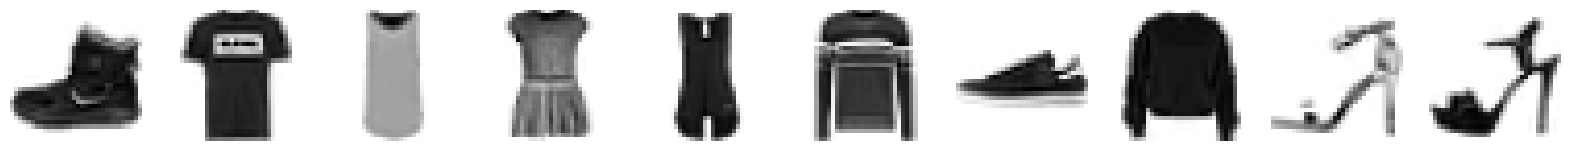

In [6]:
# Show some items of clothing from the training set
display(input_data)

# 2. Build the PixelCNN

In [7]:
# Define a Pixel CNN network
dist = tfp.distributions.PixelCNN(
    image_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    num_resnet=1,
    num_hierarchies=2,
    num_filters=32,
    num_logistic_mix=N_COMPONENTS,
    dropout_p=0.3,
)

# Define the model input
image_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

# Define the log likelihood for the loss fn
log_prob = dist.log_prob(image_input)

# Define the model
pixelcnn = models.Model(inputs=image_input, outputs=log_prob)
pixelcnn.add_loss(-tf.reduce_mean(log_prob))

2024-03-15 22:20:07.451901: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


# 3. Train the PixelCNN

In [8]:
# Compile and train the model
pixelcnn.compile(
    optimizer=optimizers.Adam(0.001),
)

In [9]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def generate(self):
        return dist.sample(self.num_img).numpy()

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate()
        display(
            generated_images,
            n=self.num_img,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )


img_generator_callback = ImageGenerator(num_img=2)

In [10]:
pixelcnn.fit(
    input_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=True,
    callbacks=[tensorboard_callback, img_generator_callback],
)

Layer _PixelCNNNetwork was created by passing
non-serializable argument values in `__init__()`,
and therefore the layer must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Epoch 1/10


2024-03-15 22:20:13.921969: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/private__pixel_cnn_network/model/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-15 22:20:15.284710: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-03-15 22:20:15.357915: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-15 22:20:17.127775: I external/local_xla/xla/service/service.cc:168] XLA service 0x7dfa38019a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-15 22:20:17.127793: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-03-15 22:20:17.131875: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:26

938/938 [==============================] - 50s 39ms/step - loss: 2215.2437
Epoch 2/10
938/938 [==============================] - 35s 38ms/step - loss: 1974.0092
Epoch 3/10
938/938 [==============================] - 35s 37ms/step - loss: 1893.9146
Epoch 4/10
938/938 [==============================] - 35s 38ms/step - loss: 1843.6238
Epoch 5/10
938/938 [==============================] - 35s 38ms/step - loss: 1815.7751
Epoch 6/10
938/938 [==============================] - 36s 38ms/step - loss: 1787.7581
Epoch 7/10
938/938 [==============================] - 36s 38ms/step - loss: 1766.7909
Epoch 8/10
938/938 [==============================] - 36s 38ms/step - loss: 1749.6774
Epoch 9/10
938/938 [==============================] - 36s 38ms/step - loss: 1733.7312
Epoch 10/10
938/938 [==============================] - 36s 38ms/step - loss: 1718.9900


# 4. Generate images

In [11]:
generated_images = img_generator_callback.generate()

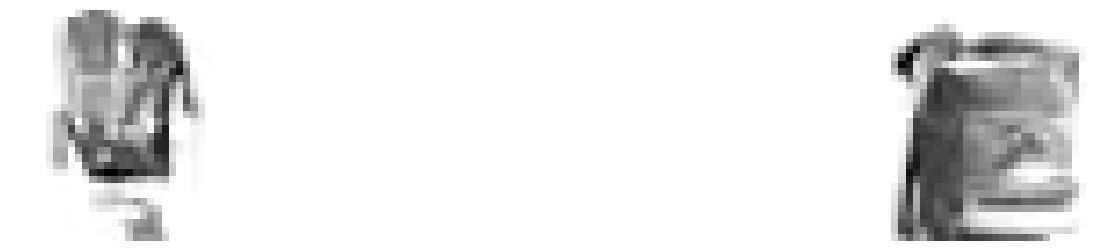

In [12]:
display(generated_images, n=img_generator_callback.num_img)